# モデルの選択・評価・過学習・正則化

この章では、機械学習モデルの選択方法、評価方法、過学習の概念、そして正則化手法について学ぶ。



## モデル選択

何らかのデータを記述するモデルを選択する際の大前提として、モデルはあくまで「データを記述するための仮説や特定の立場を採用しているに過ぎない」ことを理解しておく必要がある。

例えば特定のデータに対して、線形モデルが最も良い結果を出したとしても、そのデータセットが本当に線形であるとは限らない。データのある部分(現時点で測定データが取れる条件)だけが線形に見える場合もあるし、他のモデルがより良い結果を出す可能性もある。

回帰などにおける最尤推定は、与えられたデータに対して、選択したモデルの枠組みの中で最も尤もらしいパラメータを見つける手法である。したがって、モデルの選択は尤もらしいパラメータを見つけることとは別の問題であり、その方法論・基準は多様である。

モデルを選択する際の基準としては、以下のようなものがある。

- **モデル評価**: 複数のモデルを用意し、あらかじめ用意した評価指標(例えば交差検証など)に基づいて、最も良い結果を出すモデルを選ぶ。
- **解釈性**: モデルの構造が理解しやすく、解釈しやすいものを選ぶ。
- **計算効率**: 計算リソースや時間が限られている場合、効率的なモデルを選ぶ。
- **ドメイン知識**: 専門知識に基づいて、適切なモデルを選ぶ。

これらは相補的な場合もあれば、相反する場合もある。例えば、解釈性の高いモデルは計算効率が低いことが多い一方で、必ずしもシンプルなモデルが最も良い結果を出すとは限らない。

## モデル評価

あるモデル(例: 回帰を行う線形モデルやニューラルネットワーク)が与えられたとき、そのモデルの**性能**を、どうやって定量化して評価すればよいだろうか。
もちろん唯一の正解はないが、慣例的に用いられるものをここでは紹介する。

最も直感的な評価指標は、**あるデータをモデルに入力したとき、どれだけ正確に出力を予測できるか**である。
例えば、回帰問題においては、ある入力データ $x_i$ に対して、モデルが予測した出力を $\hat{y}_i$、実際の正解データを $y_i$ とすると、**平均二乗誤差** (Mean Squared Error, MSE) という指標がよく用いられる。

$$
\mathrm{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

当然ながら、この選択は唯一ではない。例えば、スケールの大きく異なるデータを扱う場合、MSEは大きなスケールのデータに引きずられてしまう。
例として、原子核の半減期を考えてみよう。半減期は、ミリ秒から数百万年まで、非常に広い範囲にわたる。
以下に、いくつか例を示した。

| 同位体 | 半減期 |
|--------|--------|
| ${}^{1}\mathrm{n}$ | 約10分 |
| ${}^{3}\mathrm{H}$ | 約12年 |
| ${}^{14}\mathrm{C}$ | 約5730年 |
| ${}^{131}\mathrm{I}$ | 約8日 |
| ${}^{235}\mathrm{U}$ | 約7億年 |
| ${}^{238}\mathrm{U}$ | 約45億年 |

例えば炭素14は年代測定に用いることができる。

さて、この半減期を説明し、未知の同位体についても予測してくれるようなモデルを作りたいとする。
このとき、MSEを評価指標として用いると、スケールの大きいデータに引きずられてしまい、モデルの性能を正しく評価できない。
例えば三重水素の半減期12年を1%(つまり約0.12年)の誤差で予測できて、なおかつ炭素14の半減期5730年を1%(つまり約57年)の誤差で予測できたとする。このとき、２つのデータに対するMSEは、

$$
\mathrm{MSE} = \frac{1}{2} \left( (12 - 11.88)^2 + (5730 - 5673)^2 \right) \approx 1600
$$

となり、炭素14の誤差が圧倒的に大きく寄与してしまう。この指標のもとでどれだけモデルを改善しても、三重水素の予測精度はほとんど変わらないどころか、場合によっては悪化してしまうかもしれない。このような場合、値のスケールを揃えるために対数をとったり、相対誤差を用いるなどの工夫が必要になる。

では何らかの工夫で、経験的に良さそうな評価指標を見つけたとしよう。
その際、与えられたデータに対してひたすら評価指標を改善するようにモデルを調整していくと、全てがうまく行くだろうか？
答えは必ずしもそうではない。それが、続く過学習の問題である。

## 過学習

**過学習(overfitting)** とは、**与えられたデータに対しては非常に良い性能を示すが、未知のデータに対しては性能が悪い**という現象である。

筆者が過学習の説明の際によく使うイメージ例は、受験勉強である。
これを読んでいる読者は、多かれ少なかれ、高校・大学受験や資格試験などなんらかの受験勉強をした経験があるものと想像する。
受験勉強においては、過去問を解くことが非常に重要である。
過去問を解くことで、出題傾向や難易度を把握し対策を立てることができるからである。
しかし、過去問を解くことに特化しすぎると、過去問に対しては非常に良い点数を取れるようになるが、実際の試験では点数が伸びない、ということが起こりうる。
これは、問題の本質を理解するのではなくむしろ過去問の解き方を丸暗記してしまうことが原因と考えられる。

データ分析における過学習も、これと同じような問題である。
例えば、あるデータセットに対して、非常に複雑なモデルを用いて、評価指標を徹底的に改善したとする。
このとき、そのモデルがデータの背後にある本質的なパターンを捉えていればよいのだが、データに含まれるノイズや偶然のパターンに過剰に適合してしまうことがある。このような場合、未知のデータに対しては予測性能が乏しいモデルとなってしまう。

例を示そう。以下に、1次元の入力データに対するデータ点を3点示した。

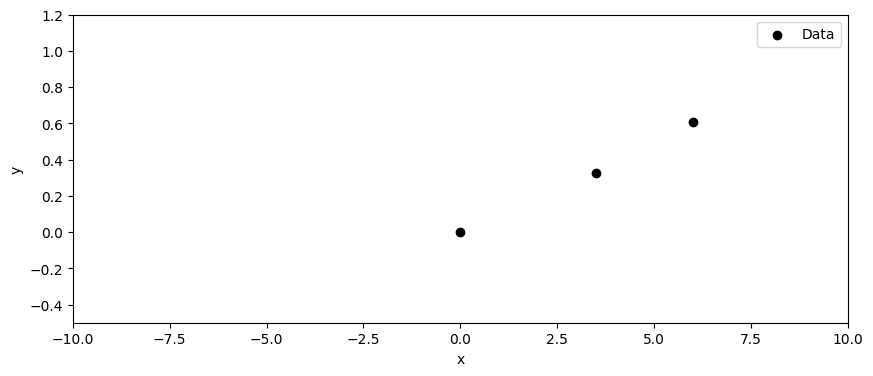

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def ftrue(x, mu=5.0, sigma=1.0):
    return np.exp(- (x-mu)**2 / (2*sigma**2) ) 

xplot = np.linspace(-20.0,20.0,500)
ytrue = ftrue(xplot)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_xlim(-10, 10); ax.set_ylim(-0.5,1.2)
xD = [ 0.0, 3.5, 6.0]
yD = ftrue(np.array(xD))
ax.scatter(xD,yD,marker="o",color="k",label="Data")
ax.legend()
plt.show()
plt.close()

なんだか直線か、ゆるやかな二次関数で説明できそうなデータである。
では二次関数だと思ってフィッティングしてみよう。

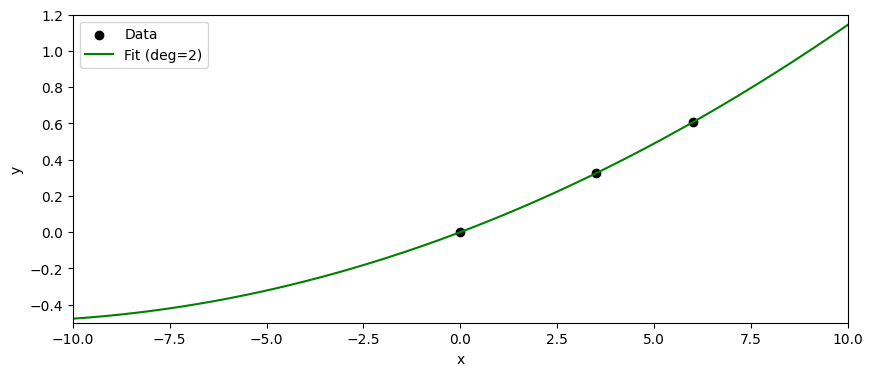

MSE = 5.370278283993142e-32


In [18]:
coeffs = np.polyfit(xD,yD,2)
yfit = np.polyval(coeffs, xplot)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_xlim(-10, 10); ax.set_ylim(-0.5,1.2)
xD = [ 0.0, 3.5, 6.0]
yD = ftrue(np.array(xD))
ax.scatter(xD,yD,marker="o",color="k",label="Data")
ax.plot(xplot, yfit, color="green", label="Fit (deg=2)")
ax.legend()
plt.show()
plt.close()

MSE = np.mean( (yD - np.polyval(coeffs, xD))**2 )
print(f"MSE = {MSE}")

バッチリ当てはまった。この場合のMSEは計算によると、ほぼ0である。(パラメータが3つあり、３つの独立な点を選んでいるので、二次関数が完全に当てはまるのは当然である。)

この二次関数に基づいて、未知のデータ点に対しても予測を行うことができる！！  
とはならない。実はこのデータは、下記のように正規分布の確率密度関数(中心=5, 分散1)から選んだ3点が、たまたま直線や二次関数で説明できそうに見えるだけである。

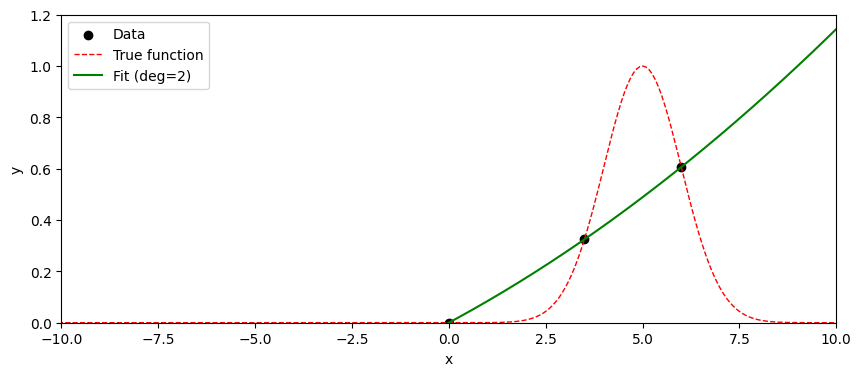

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def ftrue(x, mu=5.0, sigma=1.0):
    return np.exp(- (x-mu)**2 / (2*sigma**2) ) 

xplot = np.linspace(-20.0,20.0,500)
ytrue = ftrue(xplot)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_xlim(-10, 10); ax.set_ylim(-0.0,1.2)
xD = [ 0.0, 3.5, 6.0]
yD = ftrue(np.array(xD))
ax.scatter(xD,yD,marker="o",color="k",label="Data")
ax.plot(xplot,ytrue,label="True function",color="r",linestyle="dashed", lw=1)
ax.plot(xplot, yfit, color="green", label="Fit (deg=2)")
ax.legend()
plt.show()
plt.close()

もちろんこの例は意図的に"意地悪な"例を選んでいるが、実際のデータ分析においても、過学習はしばしば発生する。
過学習を防ぐためには、以下のような方法がある。

- データを増やす: より多くのデータを収集することで、モデルが本質的なパターンを学習しやすくなる。
- データの分割: データセットを訓練データと検証データに分割し、モデルの性能を検証データで評価することで、過学習を検出できる。
- モデルの複雑さを制限する (正則化): あまりにも複雑なモデルは過学習しやすい。例えば、線形回帰モデルを用いる場合、高次の多項式を使うと過学習が起きやすいことはよく知られている。
- 背景知識を活用する: モデルに対して、物理法則やドメイン知識などの制約を加えることで、過学習を防ぐことができる。
- 交差検証を用いる: データセットを複数の部分に分割し、各部分を順番に検証データとして使用することで、モデルの汎化性能を評価できる。

などなど。この資料の残る節ではとくに、データの分割、正則化について紹介する。

## データの分割

この節では、データの分割について説明する。これは過学習を防ぐ直接的な手法ではないが、過学習を検出するために重要な手法である。

機械学習において、モデルの性能を評価するためには、**訓練データ(training data)**、**検証データ(validation data)**、
**テストデータ(test data)** の3つにデータセットを分割することが一般的である。

- **訓練データ**: モデルの学習に使用されるデータ。モデルはこのデータを用いてパラメータを調整し、与えられたタスクを遂行できるようになる。
- **検証データ**: 複数のモデルの中から最適なモデルを選択するなど、モデルのハイパーパラメータ(アーキテクチャなど)の比較検討に使用されるデータ。訓練データとは別に用意され、モデルの汎化性能を評価するために使われる。
- **テストデータ**: 最終的なモデルの性能を評価するために使用されるデータ。訓練データや検証データには一切触れられない。

例えば、あるデータセットが1000個のデータ点から構成されているとする。このデータセットを、訓練データに70%(700個)、検証データに15%(150個)、テストデータに15%(150個)の割合で分割する、といった具合である。

データの分割は、ランダムに行うことが一般的であるが、データの性質によっては注意が必要である。
特に、時系列データや空間データなど、データ点が互いに依存している場合には、単純なランダム分割は適切でないことがある。
つまり、訓練データと検証データ、テストデータの間で情報が漏れないように注意する必要がある(leakageと呼ばれる)。

例えば犬の画像を分類するモデルを考える。
ある犬の画像が訓練データに含まれている場合、その犬の別の画像やデータの水増しに使った画像(augmented data; 例えば回転や拡大縮小、色調変更などを施した画像)が検証データやテストデータに含まれていると、モデルの性能が過大評価されてしまう。
このような場合、犬の種類ごとにデータを分割するなど、工夫が必要になる。

## 正則化

正則化(regularization)とは、モデルの複雑さを制限することで過学習を防ぐ手法である。
例えば、線形回帰モデルにおいては、パラメータの大きさを制限することで、モデルの複雑さを抑えることができることがある。
以下に、代表的な正則化手法を紹介する。



### L2正則化

L2正則化は、モデルのパラメータの二乗和をペナルティ項として損失関数に加える手法である。
例えば、線形回帰モデルにおいては、以下のように損失関数を定義する。

$$
L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{M} w_j^2
$$

ここで、$y_i$ は実際の出力、$\hat{y}_i$ はモデルの予測出力、$w_j$ はモデルのパラメータ、$\lambda$ は正則化パラメータである。
$\lambda$ の値が大きいほど、パラメータの大きさに対するペナルティが強くなり、モデルの複雑さが抑えられる。

適当なデータを用意して、線形回帰を用いてL2正則化の効果を見てみよう。



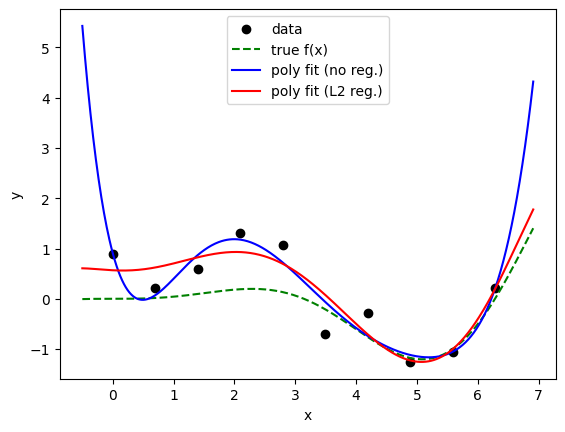

coeffs (no reg.):    0.000   -4.491    6.944   -3.807    0.953   -0.114    0.005
coeffs (L2 reg.):    0.000   -0.060    0.147    0.152   -0.126    0.025   -0.001


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge

def ftrue(x, add_noise=False):
    y = 0.05 * x**2 * np.sin(x)
    if add_noise:
        return y + 0.5 * np.random.randn(len(x))
    return y

# 疑似データ生成
np.random.seed(0)
x = np.linspace(0, 2*np.pi, 10)
y = ftrue(x, add_noise=True)
X = x.reshape(-1, 1)

# 多項式の次数
degree = 6
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# 通常の多項式回帰
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

# L2正則化（Ridge回帰）
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_poly, y)

# 可視化用の滑らかなデータ
t = np.linspace(-0.5, 2.2*np.pi, 500).reshape(-1, 1)
t_poly = poly.transform(t)
y_lin = lin_reg.predict(t_poly)
y_ridge = ridge_reg.predict(t_poly)

# プロット
plt.scatter(x, y, color="black", label="data")
plt.plot(t, ftrue(t), "g--", label="true f(x)")
plt.plot(t, y_lin, "b-", label="poly fit (no reg.)")
plt.plot(t, y_ridge, "r-", label="poly fit (L2 reg.)")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print("coeffs (no reg.):", " ".join(f"{c:8.3f}" for c in lin_reg.coef_))
print("coeffs (L2 reg.):", " ".join(f"{c:8.3f}" for c in ridge_reg.coef_))

上では、$ 0.05  x^2  \sin(x) $ という関数にノイズを加えたデータを用意した。
6次の多項式でフィッティングしているが、L2正則化を用いない場合は過学習してしまい、未知のデータに対する予測性能が悪い。
実際に得られた係数も、L2正則化を用いない場合は非常に大きな値になっているのに対し、L2正則化を用いた場合は比較的小さな値に抑えられている事がわかる。
上記の例はあくまで、たまたまノイズの多いデータに対して過学習が起きた＆L2正則化がうまく働いた(ように見える)例である。

一般の場合においても、L2正則化は過学習を防ぐ効果があることが多いが、必ずしも万能ではないことに注意が必要である。
線形回帰の章で進んだ注として紹介したように、ベイズ線形回帰の文脈では、L2正則化はパラメータに対するガウス事前分布を仮定することに対応する。



### L1正則化 (Lasso)

L1正則化は、モデルのパラメータの絶対値の和をペナルティ項として損失関数に加える手法である。
例えば、線形回帰モデルにおいては、以下のように損失関数を定義する。

$$
L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{M} |w_j|
$$  

L2正則化と同様に、$\lambda$ は正則化パラメータであり、その値が大きいほどパラメータの大きさに対するペナルティが強くなる。
L1正則化の特徴は、パラメータの一部をゼロにする傾向があることである。これにより、モデルの解釈性が向上し、重要な特徴量の選択にもつながることがある。
このことから、L1正則化は **Lasso (Least Absolute Shrinkage and Selection Operator)** や **スパース正則化 (Sparse Regularization)** とも呼ばれる。

上の例にL1正則化を適用してみよう。
その効果をはっきりとみるために、あえて高次の多項式(9次)でフィッティングしてみた。
L1正則化がスパースな解をもたらすのであれば、9次の多項式のうち、多くの係数がゼロになることが期待される。

/Users/sym4p/my_python3_env_forQC/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.795e-01, tolerance: 7.214e-04
  model = cd_fast.enet_coordinate_descent(


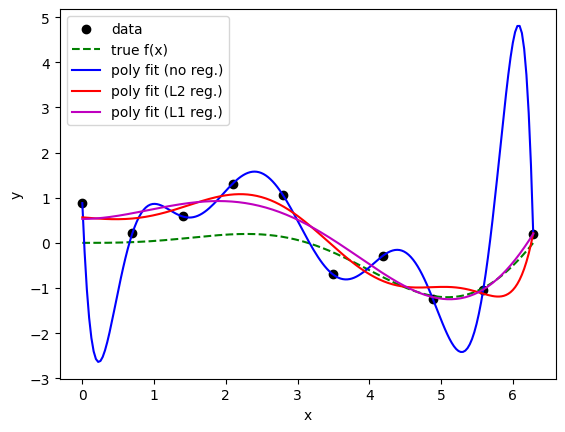

coeffs (no reg.):    0.000  -38.418  140.647 -208.584  163.228  -74.026   20.074   -3.205    0.278   -0.010
coeffs (L2 reg.):    0.000   -0.140    0.030    0.140    0.091   -0.081    0.000    0.008   -0.002    0.000
coeffs (L1 reg.):    0.000   -0.000    0.352   -0.130   -0.002    0.001    0.000    0.000   -0.000   -0.000


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso


def ftrue(x, add_noise=False):
    y = 0.05 * x**2 * np.sin(x)
    if add_noise:
        return y + 0.5 * np.random.randn(len(x))
    return y

# 疑似データ生成
np.random.seed(0)
x = np.linspace(0, 2*np.pi, 10)
y = ftrue(x, add_noise=True)
X = x.reshape(-1, 1)

# 多項式の次数
degree = 9
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# 通常の多項式回帰
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)


# L2正則化（Ridge回帰）
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_poly, y)


# L1正則化（Lasso回帰）
lasso_reg = Lasso(alpha=0.01, max_iter=10000)
lasso_reg.fit(X_poly, y)


# 可視化用の滑らかなデータ
t = np.linspace(0, 2*np.pi, 200).reshape(-1, 1)
t_poly = poly.transform(t)
y_lin = lin_reg.predict(t_poly)
y_ridge = ridge_reg.predict(t_poly)
y_lasso = lasso_reg.predict(t_poly)

# プロット
plt.scatter(x, y, color="black", label="data")
plt.plot(t, ftrue(t), "g--", label="true f(x)")
plt.plot(t, y_lin, "b-", label="poly fit (no reg.)")          
plt.plot(t, y_ridge, "r-", label="poly fit (L2 reg.)")
plt.plot(t, y_lasso, "m-", label="poly fit (L1 reg.)")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()  

print("coeffs (no reg.):", " ".join(f"{c:8.3f}" for c in lin_reg.coef_))
print("coeffs (L2 reg.):", " ".join(f"{c:8.3f}" for c in ridge_reg.coef_))
print("coeffs (L1 reg.):", " ".join(f"{c:8.3f}" for c in lasso_reg.coef_))

(表示の桁にもよるし)厳密に0になっている訳では無いが、L1正則化を用いた場合、多くの係数がゼロに近い値になっていることがわかる。

正則化なしの場合はあきらかに過学習しているが、L1正則化を用いることで、過学習が抑えられていることがわかる。